<a href="https://colab.research.google.com/github/ghadaghalleb/Pneumonia-Detection-Using-Deep-Learning/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle


In [ ]:
! mkdir ~/.kaggle/ 

In [ ]:
! cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/  

In [ ]:
! chmod 600  ~/.kaggle/kaggle.json 

In [ ]:
! kaggle datasets list 

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                          Spotify and Youtube                                   9MB  2023-03-20 15:43:25           9654        340  1.0              
arnabchaki/data-science-salaries-2023                          Data Science Salaries 2023  💸                        25KB  2023-04-13 09:55:16           3206         77  1.0              
erdemtaha/cancer-data                                          Cancer Data                                          49KB  2023-03-22 07:57:00           4546        100  1.0              
evangower/premier-league-2022-2023                             Pr

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:02<00:00, 46.3MB/s]
100% 2.29G/2.29G [01:03<00:00, 39.1MB/s]


In [ ]:
! unzip /content/drive/MyDrive/Kaggle/chest-xray-pneumonia.zip -d pneumoniadata 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: pneumoniadata/chest_xray/train/N

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/pneumoniadata/chest_xray/train')
test = get_training_data('/content/pneumoniadata/chest_xray/test')
val = get_training_data('/content/pneumoniadata/chest_xray/val')

<ipython-input-11-149d7cc0a3f4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


PNEUMONIA


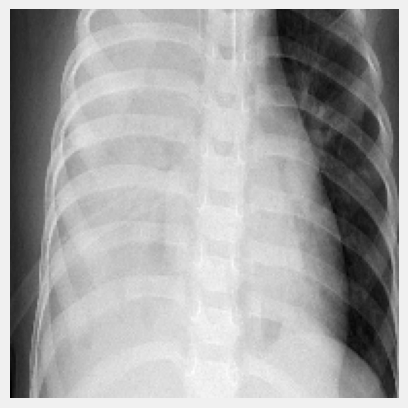

In [ ]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

In [ ]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [ ]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 256)    400       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 [==============================] - 41s 72ms/step - loss: 0.6018 - acc: 0.7248 - val_loss: 1.1417 - val_acc: 0.7407
Epoch 2/15
375/375 [==============================] - 23s 62ms/step - loss: 0.4552 - acc: 0.7699 - val_loss: 0.3241 - val_acc: 0.8655
Epoch 3/15
375/375 [==============================] - 23s 61ms/step - loss: 0.3990 - acc: 0.8076 - val_loss: 0.3377 - val_acc: 0.8762
Epoch 4/15
375/375 [==============================] - 24s 64ms/step - loss: 0.3637 - acc: 0.8335 - val_loss: 0.3121 - val_acc: 0.8442
Epoch 5/15
375/375 [==============================] - 24s 65ms/step - loss: 0.3510 - acc: 0.8417 - val_loss: 0.2486 - val_acc: 0.8986
Epoch 6/15
375/375 [==============================] - 24s 65ms/step - loss: 0.3365 - acc: 0.8548 - val_loss: 0.2532 - val_acc: 0.8933
Epoch 7/15
375/375 [==============================] - 23s 62ms/step - loss: 0.3240 - acc: 0.8607 - val_loss: 0.2672 - val_acc: 0.8847
Epoch 8/15
375/375 [==============================] - 24s 64ms

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 2s 65ms/step - loss: 0.2280 - acc: 0.9147


[0.22804315388202667, 0.914675772190094]

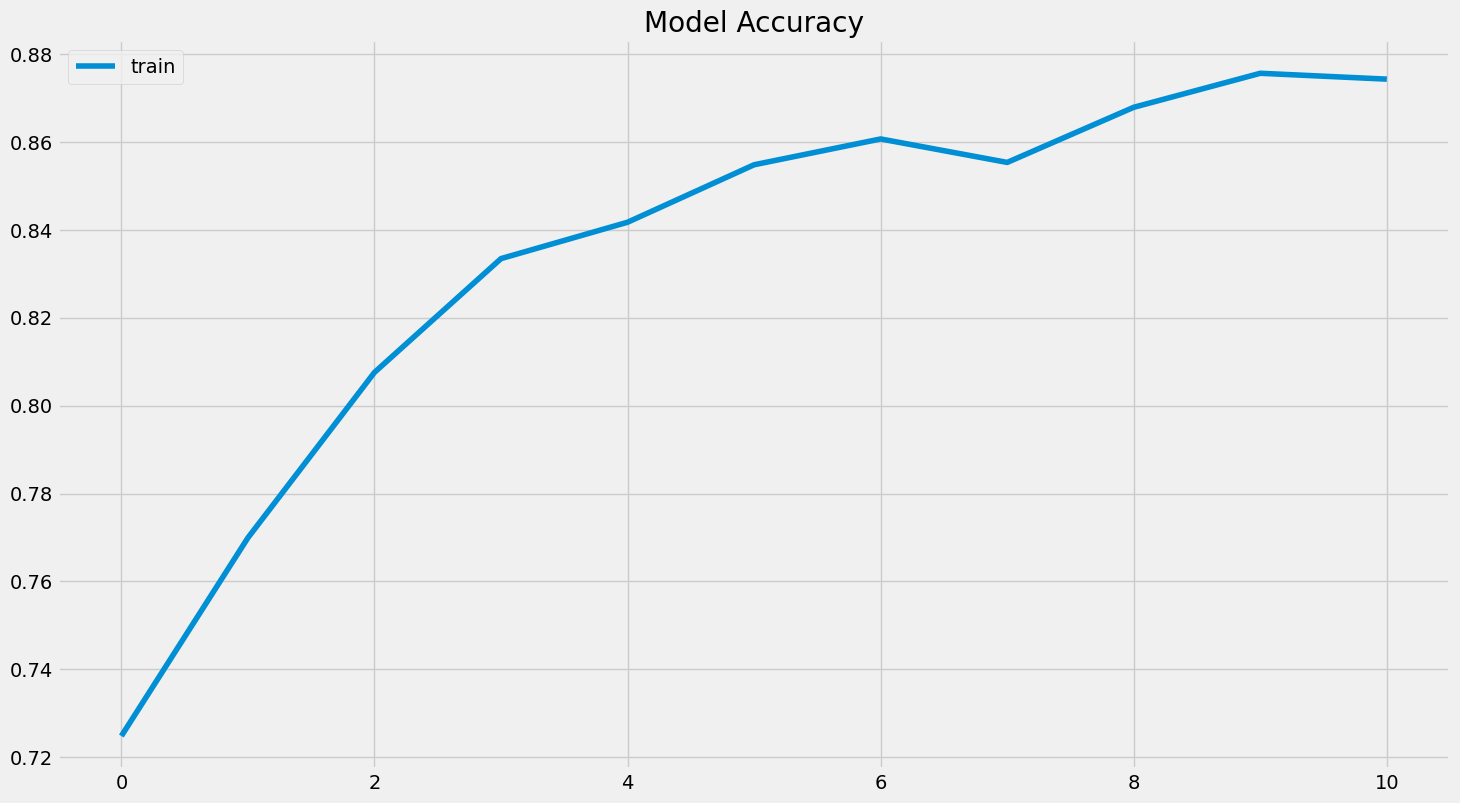

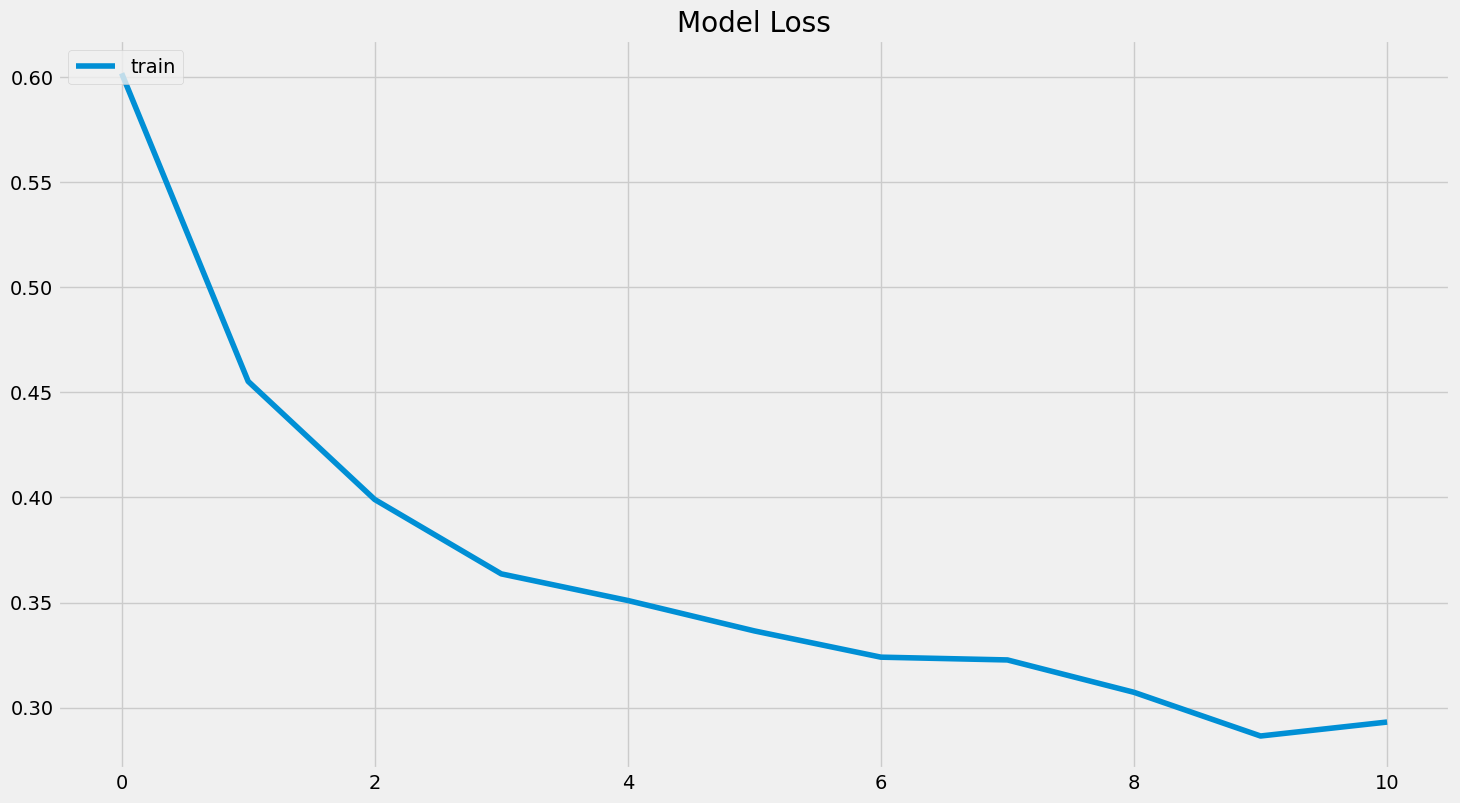

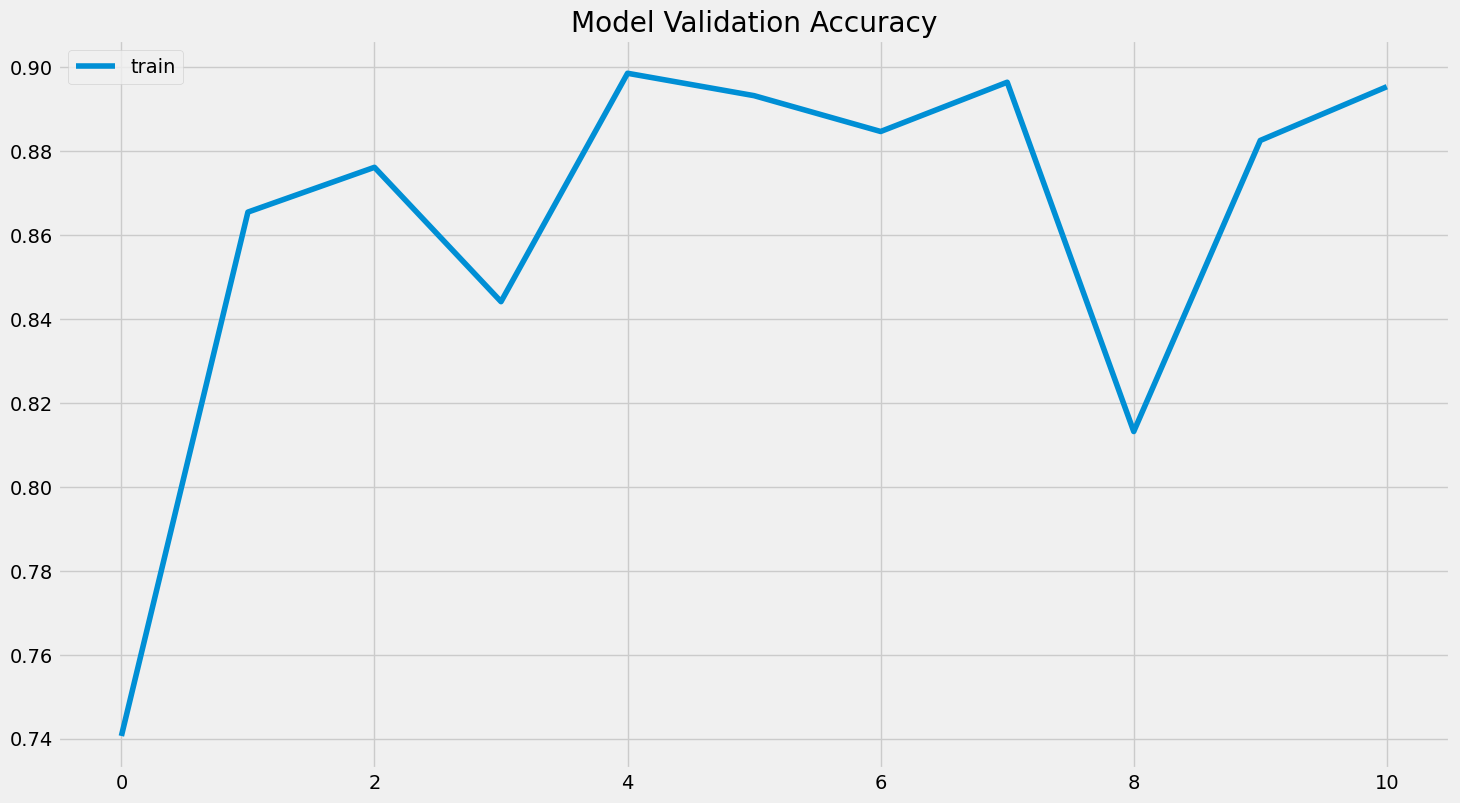

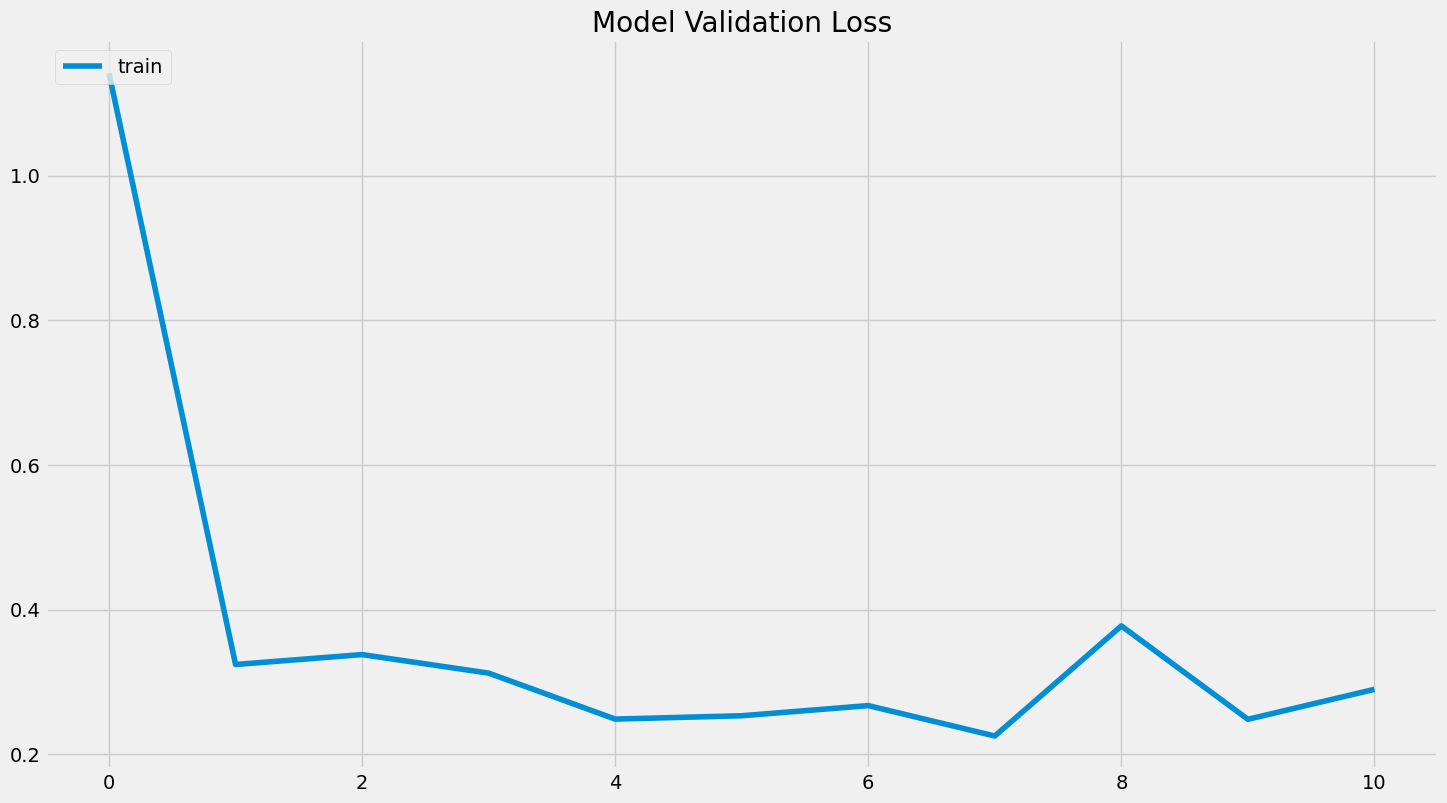

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 [==============================] - 6s 43ms/step


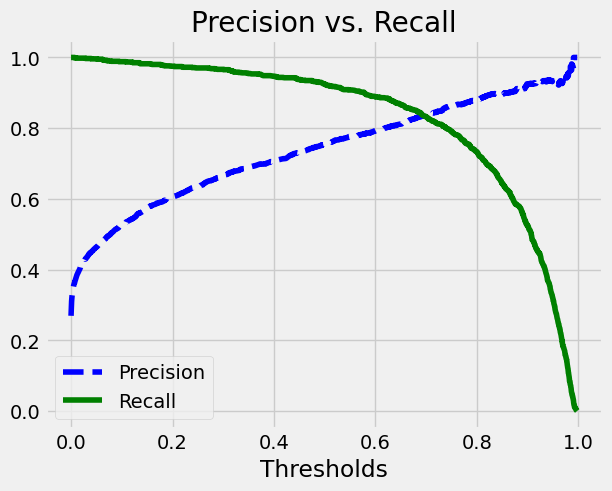

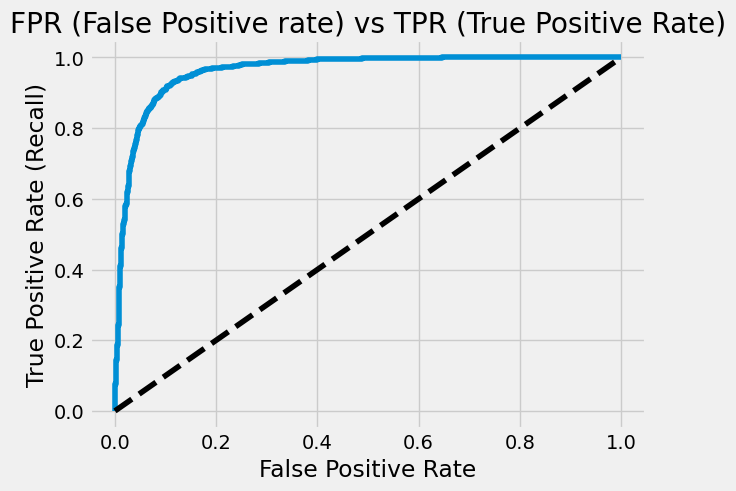

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(X_test)

37/37 [==============================] - 1s 40ms/step


In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.924061433447099
Precision on testing set: 0.8875379939209727
Recall on testing set: 0.8488372093023255


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

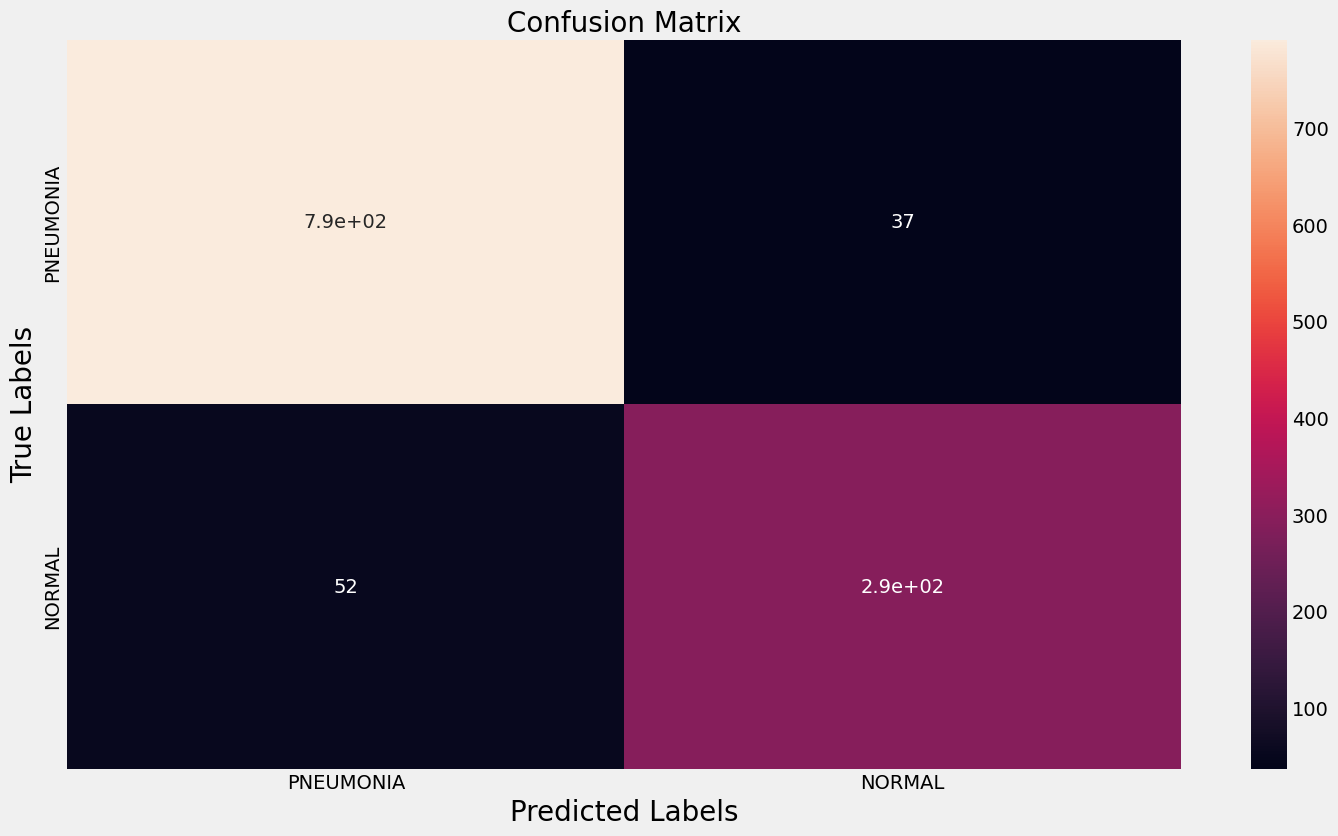

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

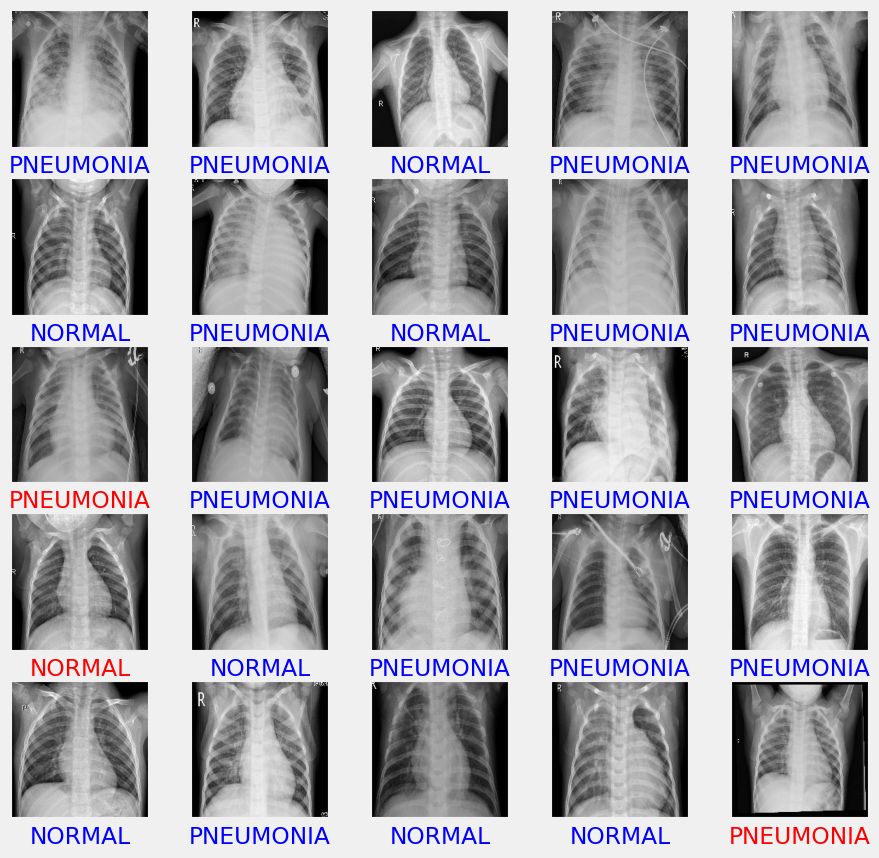

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()


In [ ]:
model.save('pneumonia_detection_ai_version_3.h5')